# Risk Model with ML

In [1]:
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
"""
#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
"""
#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### DATA Raw

In [2]:

data = pd.io.stata.read_stata('../Base imputada EFH 2021.dta')
data.to_csv('../my_stata_file2021.csv')

# load dataset
dataset = pd.read_csv('../my_stata_file2021.csv')

In [3]:
dataset.head()

,Unnamed: 0,imp,id,factor,genero_ent,edad_ent,tr_edad_ent,nacionalidad_ent,educ_ent,neduc_ent,...,u_tnbco,u_prepago,u_cheq,u_pat,u_transf,u_bip,u_tcripto,u_pel,u_tprepago,u_pac
0,0,0.0,10002.0,2356.0,Mujer,37,entre 35 y 49,Chileno(a),12.0,Ed. Básica,...,No,No,No,No,Si,No,No,Si,No,No
1,1,0.0,10003.0,1232.0,Hombre,76,igual o mayor a 65,Chileno(a),12.0,Ed. Básica,...,No,Si,No,Si,No,No,No,Si,No,No
2,2,0.0,10004.0,1927.0,Hombre,69,igual o mayor a 65,Chileno(a),6.0,Ed. diferencial,...,No,No,No,No,Si,No,No,No,No,No
3,3,0.0,10005.0,2573.0,Mujer,45,entre 35 y 49,Chileno(a),12.0,Ed. Básica,...,No,No,No,No,Si,Si,No,Si,No,No
4,4,0.0,10006.0,1796.0,Hombre,60,entre 50 y 64,Peruano(a),9.0,Ed. Básica,...,No,No,No,No,No,Si,No,No,Si,No


In [7]:
dataset["rci_dt"]

0         0.655405
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
136395    1.158861
136396    0.134831
136397    0.240730
136398    0.000000
136399    0.000000
Name: rci_dt, Length: 136400, dtype: float64

## DATA 2 Values

In [8]:
dataset.loc[dataset["neduc_ent"] == "Sin educación", "neduc_ent"] = 0.0
dataset.loc[dataset["neduc_ent"] == "Ed. diferencial", "neduc_ent"] = 1.0
dataset.loc[dataset["neduc_ent"] == "Ed. Básica", "neduc_ent"] = 2.0
dataset.loc[dataset["neduc_ent"] == "Ed. Media", "neduc_ent"] = 3.0
dataset.loc[dataset["neduc_ent"] == "CFT o IP", "neduc_ent"] = 4.0
dataset.loc[dataset["neduc_ent"] == "Universitaria", "neduc_ent"] = 5.0
dataset.loc[dataset["neduc_ent"] == "Postgrado", "neduc_ent"] = 6.0

In [9]:
dataset.loc[dataset["tr_numh"] == "7 o más personas en el hogar", "tr_numh"] = 4.0
dataset.loc[dataset["tr_numh"] == "entre 1 y 2 personas en el hogar", "tr_numh"] = 1.0
dataset.loc[dataset["tr_numh"] == "entre 3 y 4 personas en el hogar", "tr_numh"] = 2.0
dataset.loc[dataset["tr_numh"] == "entre 5 y 6 personas en el hogar", "tr_numh"] = 3.0
dataset.loc[dataset["tr_numh"] == "más de 6 personas en el hogar", "tr_numh"] = 4.0

In [10]:
dataset.loc[dataset["est_civil_ent"] == "Casado(a)", "est_civil_ent"] = 1.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente o pareja", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente o pareja sin acuerdo de unión civil", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Conviviente civil (con acuerdo)", "est_civil_ent"] = 2.0
dataset.loc[dataset["est_civil_ent"] == "Anulado", "est_civil_ent"] = 3.0
dataset.loc[dataset["est_civil_ent"] == "Anulado(a)", "est_civil_ent"] = 3.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a)", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a) de union de hecho", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Separado(a) de union legal", "est_civil_ent"] = 4.0
dataset.loc[dataset["est_civil_ent"] == "Viudo(a)", "est_civil_ent"] = 5.0
dataset.loc[dataset["est_civil_ent"] == "Soltero(a)", "est_civil_ent"] = 6.0
dataset.loc[dataset["est_civil_ent"] == "Divorciado(a)", "est_civil_ent"] = 7.0

In [11]:
dataset.loc[dataset["ocup_ent"] == "Desocupado", "ocup_ent"] = 0.0
dataset.loc[dataset["ocup_ent"] == "Ocupado", "ocup_ent"] = 1.0

In [12]:
dataset['estrato'] = dataset['estrato'].map(lambda x: int(x.split("Deciles")[1].split("al")[0]))

In [13]:
set(dataset['estrato'])

{1, 6, 9}

### Adding a Risk Features

Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows:
Risky assets is investments in mutual funds, stocks, bonds, commodities, and real estate, and an estimate of human capital.
Risk Free Assets: checking and savings balances,certificates of deposit, and other cash balances and equivalents.

According to the glossary: risky = act_var, risk free= act_fijo + act_ahcta . (we could to these add the category of "activos reales" ?? the quantity "ahorros" = t_habah, habah_m and habah_f should definetely be part of the learning, this is an indication of how the family raises money)

the value equivalent to KIDS is in my opion "numh", AGE is "edad_pr", EDUC is "neduc_pr" (we take "educ_pr" as this is a number) , married is "est_civil_pr", OCCU is "ocup_pr", INCOME is "estrato", NETWORTH is "act_toth", RISK isnt really there. 

In [14]:
keep_list2 = ['estrato','rci_dt','tr_numh','edad_ent','neduc_ent','est_civil_ent','ocup_ent','act_ahcta','act_fin','act_finvar','act_finfija','act_toth']

drop_list2 = [col for col in dataset.columns if col not in keep_list2]

dataset.drop(labels=drop_list2, axis=1, inplace=True)

In [15]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt
0,37,2.0,1.0,1.0,6,3.0,2160000.0,0.0,NaN,0.655405
1,76,2.0,1.0,0.0,1,1.0,NaN,0.0,NaN,0.000000
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000


In [16]:
set(dataset['neduc_ent'])

{1.0, 2.0, 3.0, 4.0, 5.0, nan}

In [17]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [18]:
# Drop the rows containing NA
dataset=dataset.dropna(axis=0)

dataset=dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [19]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000
5,74,1.0,6.0,0.0,1,1.0,0.0,90000.0,165540000.0,0.074697
6,65,1.0,4.0,0.0,1,1.0,0.0,0.0,40000000.0,0.000000


### Adding Risk Tolerance 

In [20]:

#Risk Tolerance 

#USAR ESTO PARA DATOS DE 2017 dataset['act_fin'] = dataset['act_finvar']+dataset['act_finfija']
dataset['RT'] = dataset['act_fin']/(dataset['act_ahcta']+dataset['act_fin'])

In [21]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
2,69,1.0,1.0,0.0,1,2.0,0.0,0.0,62000000.0,0.000000,NaN
3,45,2.0,1.0,1.0,6,3.0,0.0,0.0,92500000.0,0.000000,NaN
4,60,2.0,6.0,1.0,1,3.0,0.0,0.0,80000000.0,0.000000,NaN
5,74,1.0,6.0,0.0,1,1.0,0.0,90000.0,165540000.0,0.074697,0.0
6,65,1.0,4.0,0.0,1,1.0,0.0,0.0,40000000.0,0.000000,NaN


In [22]:
dataset = dataset[dataset['act_fin'] > 100000]  

In [23]:
dataset = dataset[dataset['act_ahcta'] > 100000]  

In [24]:
dataset = dataset[dataset['rci_dt'] > 0] 

In [25]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [26]:
# Drop the rows containing NA
dataset=dataset.dropna(axis=0)

dataset=dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [27]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
7,43,4.0,1.0,1.0,9,3.0,600000.0,30000000.0,3.456273e+08,0.249307,0.019608
17,50,4.0,6.0,1.0,9,2.0,3000000.0,400000.0,3.034000e+08,2.686299,0.882353
23,53,3.0,2.0,1.0,9,1.0,31000000.0,3000000.0,1.943485e+08,0.182609,0.911765
29,37,4.0,1.0,1.0,9,2.0,4600000.0,500000.0,1.269440e+08,0.059524,0.901961
37,44,4.0,1.0,1.0,9,2.0,6400000.0,5000000.0,3.874000e+08,0.381481,0.561404


In [28]:
datasetoriginal=dataset.copy() ### Backup

### Dataset 2 work with

In [29]:
dataset = dataset.reset_index()

In [30]:
dataset = dataset.drop(columns=['index'])

In [31]:
dataset.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
0,43,4.0,1.0,1.0,9,3.0,600000.0,30000000.0,3.456273e+08,0.249307,0.019608
1,50,4.0,6.0,1.0,9,2.0,3000000.0,400000.0,3.034000e+08,2.686299,0.882353
2,53,3.0,2.0,1.0,9,1.0,31000000.0,3000000.0,1.943485e+08,0.182609,0.911765
3,37,4.0,1.0,1.0,9,2.0,4600000.0,500000.0,1.269440e+08,0.059524,0.901961
4,44,4.0,1.0,1.0,9,2.0,6400000.0,5000000.0,3.874000e+08,0.381481,0.561404


In [32]:
dataset['neduc_ent'] =dataset['neduc_ent'].astype(float)

In [33]:
dataset['est_civil_ent'] =dataset['est_civil_ent'].astype(float)

In [34]:
dataset['ocup_ent'] =dataset['ocup_ent'].astype(float)

In [35]:
dataset['tr_numh'] =dataset['tr_numh'].astype(float)

### correlation

<AxesSubplot: title={'center': 'Correlation Matrix'}>

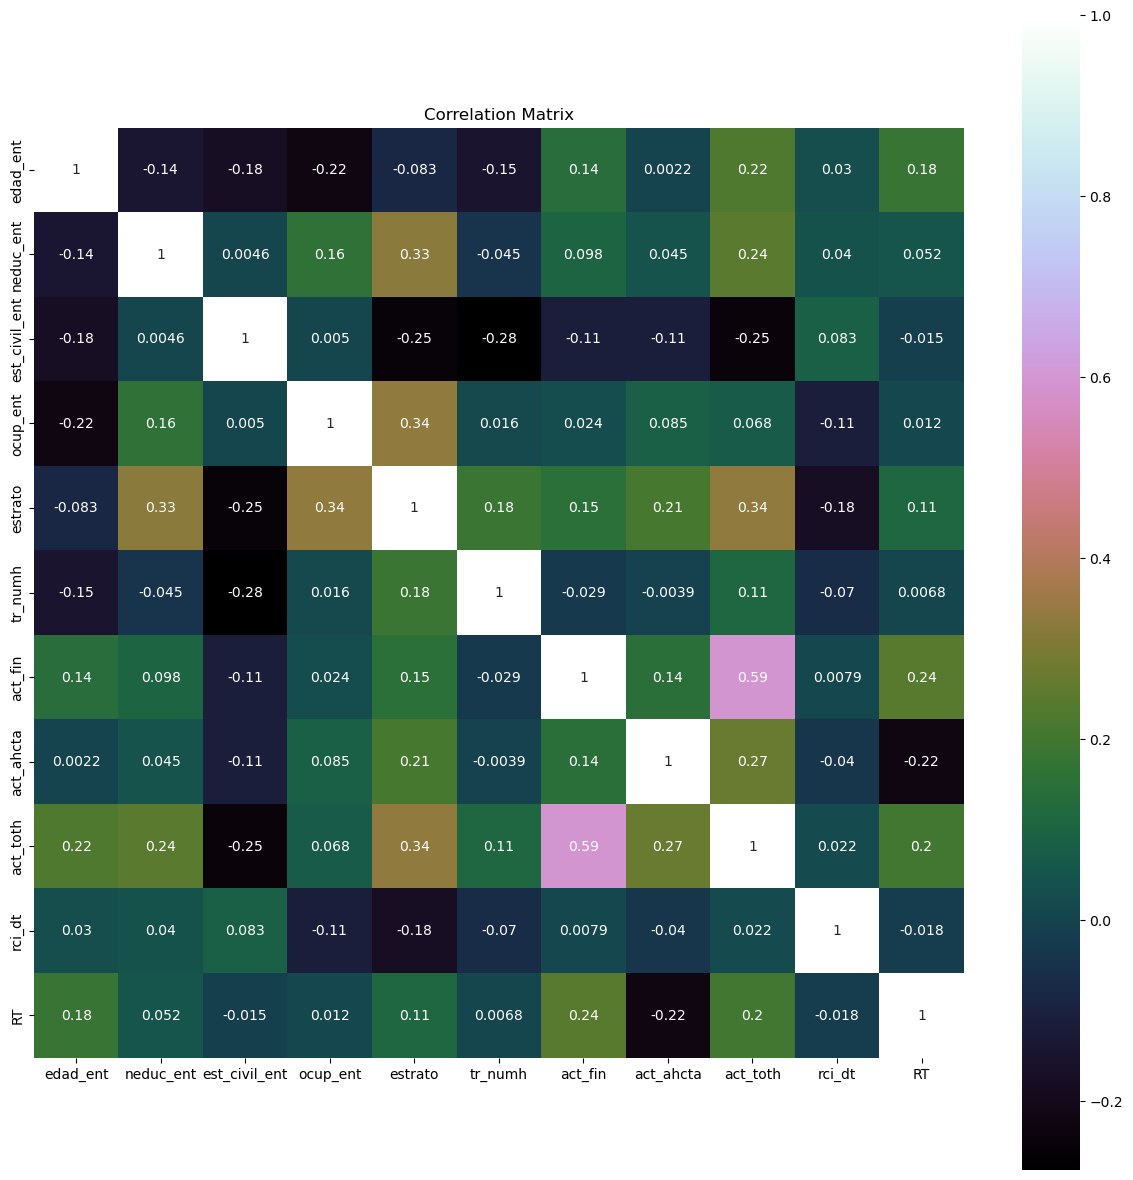

In [36]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [37]:
correlation

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_fin,act_ahcta,act_toth,rci_dt,RT
edad_ent,1.000000,-0.142153,-0.181975,-0.223472,-0.083350,-0.149457,0.138714,0.002240,0.223200,0.029651,0.177829
neduc_ent,-0.142153,1.000000,0.004558,0.158232,0.325602,-0.044643,0.097925,0.045461,0.244043,0.039678,0.052282
est_civil_ent,-0.181975,0.004558,1.000000,0.005012,-0.249912,-0.276761,-0.113904,-0.112357,-0.245508,0.082794,-0.015407
ocup_ent,-0.223472,0.158232,0.005012,1.000000,0.335813,0.016111,0.024224,0.084995,0.067768,-0.114990,0.012099
estrato,-0.083350,0.325602,-0.249912,0.335813,1.000000,0.182180,0.147807,0.210674,0.336357,-0.177965,0.107838
tr_numh,-0.149457,-0.044643,-0.276761,0.016111,0.182180,1.000000,-0.028548,-0.003873,0.111738,-0.069598,0.006845
act_fin,0.138714,0.097925,-0.113904,0.024224,0.147807,-0.028548,1.000000,0.143836,0.594953,0.007903,0.239448
act_ahcta,0.002240,0.045461,-0.112357,0.084995,0.210674,-0.003873,0.143836,1.000000,0.271458,-0.039699,-0.223922
act_toth,0.223200,0.244043,-0.245508,0.067768,0.336357,0.111738,0.594953,0.271458,1.000000,0.021543,0.200284
rci_dt,0.029651,0.039678,0.082794,-0.114990,-0.177965,-0.069598,0.007903,-0.039699,0.021543,1.000000,-0.017901


### Filtering columns

In [40]:
dataset.columns

Index(['edad_ent', 'neduc_ent', 'est_civil_ent', 'ocup_ent', 'estrato',
       'tr_numh', 'act_fin', 'act_ahcta', 'act_toth', 'rci_dt', 'RT'],
      dtype='object')

In [41]:
# split out validation dataset for the end
Y= dataset['RT']
#X = dataset[['edad_ent', 'neduc_ent', 'ocup_ent','est_civil_ent','estrato','act_toth', 'tr_numh','rci_dt']]
X = dataset.loc[:, dataset.columns != 'RT']

In [42]:
X = X.loc[:, X.columns != 'act_ahcta']

In [43]:
X = X.loc[:, X.columns != 'act_fin']

In [44]:
X = X.loc[:, X.columns != 'act_finvar']

In [45]:
X = X.loc[:, X.columns != 'act_finfija']

In [46]:
X = X.loc[:, X.columns != 'rci_dt']

In [47]:
X = X.loc[:, X.columns != 'estrato']

In [48]:
X.head()

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,tr_numh,act_toth
0,43,4.0,1.0,1.0,3.0,3.456273e+08
1,50,4.0,6.0,1.0,2.0,3.034000e+08
2,53,3.0,2.0,1.0,1.0,1.943485e+08
3,37,4.0,1.0,1.0,2.0,1.269440e+08
4,44,4.0,1.0,1.0,2.0,3.874000e+08


In [49]:
X.count()

edad_ent         11709
neduc_ent        11709
est_civil_ent    11709
ocup_ent         11709
tr_numh          11709
act_toth         11709
dtype: int64

## Train/Test Split on RT

In [50]:
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [51]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

## Models

In [52]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [53]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.063769 (0.012609)
LASSO: 0.040514 (0.005901)
EN: 0.040651 (0.005882)
KNN: 0.782761 (0.025295)
SVR: 0.041224 (0.025690)
ABR: 0.127268 (0.023343)
GBR: 0.500846 (0.014019)
RFR: 0.911621 (0.013867)
ETR: 0.909920 (0.015738)


### Obs
We find that the best models are RandomForest and Extra Tree Regressors

### HyperTuning

In [54]:
'''
n_estimators : integer, optional (default=10)
        The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, \
      cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


KeyboardInterrupt



In [70]:
help(model)

Help on RandomForestRegressor in module sklearn.ensemble._forest object:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ---------

In [55]:
y_predict = model.predict(X_validation)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [47]:
X_validation

,edad_ent,neduc_ent,est_civil_ent,ocup_ent,estrato,tr_numh,act_toth,rci_dt
11368,21,4.0,6.0,1.0,9,2.0,9.090000e+08,0.340100
8151,61,4.0,1.0,1.0,9,2.0,4.540000e+08,0.230000
5263,38,4.0,1.0,1.0,9,2.0,2.903576e+08,0.113514
7283,44,2.0,1.0,1.0,9,1.0,7.531619e+07,0.035557
3969,44,4.0,1.0,1.0,6,3.0,1.035000e+08,0.178295
...,...,...,...,...,...,...,...,...
11193,29,3.0,6.0,1.0,6,2.0,8.440000e+06,0.242582
6537,82,2.0,5.0,0.0,1,1.0,2.805000e+08,0.300000
9465,21,4.0,6.0,1.0,9,2.0,9.090000e+08,0.340100
3883,39,5.0,6.0,1.0,9,1.0,1.750000e+08,0.306393


In [56]:
models[7][1].fit(X_train, Y_train)

RandomForestRegressor()

In [57]:

y_predict = models[7][1].predict(X_validation)

(array([ 53.,  39.,  53.,  24.,  49.,  33.,  15.,  21.,  48.,  60.,  37.,
         30.,  36.,  39., 119.,  51.,  60.,  75.,  55., 106.,  54.,  94.,
         69., 121., 160.,  93., 132., 196., 204., 216.]),
 array([0.01477833, 0.04757664, 0.08037496, 0.11317327, 0.14597159,
        0.1787699 , 0.21156822, 0.24436653, 0.27716485, 0.30996317,
        0.34276148, 0.3755598 , 0.40835811, 0.44115643, 0.47395474,
        0.50675306, 0.53955138, 0.57234969, 0.60514801, 0.63794632,
        0.67074464, 0.70354295, 0.73634127, 0.76913959, 0.8019379 ,
        0.83473622, 0.86753453, 0.90033285, 0.93313116, 0.96592948,
        0.9987278 ]),
 <BarContainer object of 30 artists>)

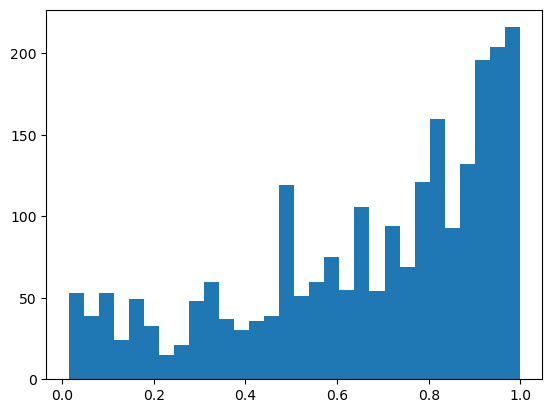

In [63]:
plt.hist(y_predict,bins = 30)


(array([  4.,   2.,  15.,   1.,  34.,  34.,  27.,  37.,  67.,  36.,  14.,
         35.,  39.,  53.,  34.,  38., 118., 187., 216., 310., 228., 219.,
        156., 162., 114.,  57.,  27.,  35.,  31.,  12.]),
 array([5.90308999, 6.02027191, 6.13745382, 6.25463574, 6.37181766,
        6.48899958, 6.6061815 , 6.72336342, 6.84054534, 6.95772726,
        7.07490917, 7.19209109, 7.30927301, 7.42645493, 7.54363685,
        7.66081877, 7.77800069, 7.89518261, 8.01236452, 8.12954644,
        8.24672836, 8.36391028, 8.4810922 , 8.59827412, 8.71545604,
        8.83263796, 8.94981987, 9.06700179, 9.18418371, 9.30136563,
        9.41854755]),
 <BarContainer object of 30 artists>)

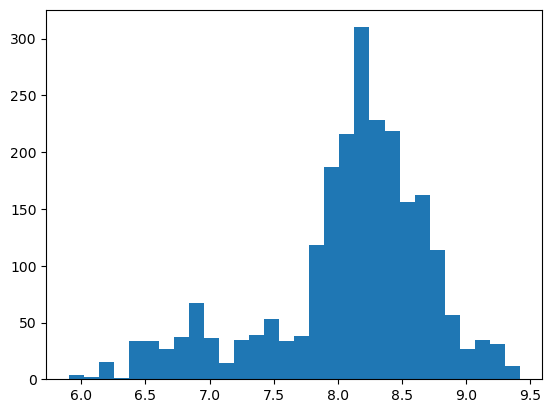

In [68]:
plt.hist(np.log10(X_validation["act_toth"]),bins = 30)


Text(0, 0.5, 'Riesgo')

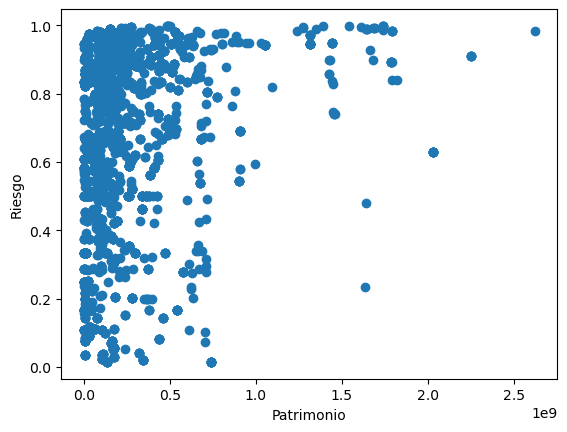

In [66]:
plt.scatter(X_validation["act_toth"],y_predict)
plt.xlabel("Patrimonio")
plt.ylabel("Riesgo")

In [58]:
for y_pred,y_true in zip(Y_validation,y_predict):
    print(y_pred,y_true)

0.6923076923076923 0.692307692307693
0.6666666666666666 0.6666666666666659
0.9090909090909091 0.9090909090909076
0.06666691555548919 0.40514948807682083
0.6 0.600000000000001
0.5555555555555556 0.5555555555555567
0.6973365635754445 0.697336563575446
0.4 0.3999999999999993
0.9 0.9000000000000008
0.9047619138321987 0.9047619138321994
0.8823529550172994 0.8875969376726328
0.819672131147541 0.8196721311475413
0.9166666705246912 0.9166666705246912
0.631578947368421 0.6315789473684195
0.75 0.75
0.9166666705246912 0.9166666705246912
0.10714285714285714 0.15168859094358728
0.5384616094674447 0.5384616094674454
0.9904761904761905 0.9904761904761881
0.5263157894736842 0.5263157894736848
0.8636363636363636 0.8636363636363638
0.10841654778887304 0.10841654778887325
0.8333333333333334 0.833333333333333
0.9745762711864406 0.6813366693991866
0.8333333333333334 0.833333333333333
0.7142857142857143 0.7142857142857142
0.27927927927927926 0.2792792792792795
0.9452054794520548 0.945205479452056
0.77611940

## Final Model

In [59]:
model = RandomForestRegressor(n_estimators = 200)

model.fit(X,Y)

RandomForestRegressor(n_estimators=200)

### Export Model

In [60]:
with open("risk_model_2.p","wb") as f:
    dump(model,f)